In [2]:
import os
import sys
import pandas as pd
import numpy as np
import requests
import math
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import ast
import re
#from dataprep.clean import clean_address
import seaborn as sns
from datetime import datetime, date
from sklearn import metrics, ensemble, preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, brier_score_loss,  f1_score, log_loss,
                             precision_score, recall_score,roc_auc_score, accuracy_score,confusion_matrix, 
                             classification_report,cohen_kappa_score, make_scorer)
from sklearn.feature_selection import mutual_info_classif   
from scipy import stats
from sklearn import calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import folium #for muti-maps
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline
from lazypredict.Supervised import LazyClassifier

import random
import time
import censusgeocode as cg  #MODEL_CONFIG
import censusdata
import csv


pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
def unique (df):
    dfun = df.nunique(axis=0)
    dfun_df = pd.DataFrame(dfun) 
    column_names=["Distinct"]
    dfun_df.columns = column_names
    dfun_df_sorted = dfun_df.sort_values('Distinct', ascending=False)
    return (dfun_df_sorted)

def check_missing_values (df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    if missing_value_df['percent_missing'].any():
        return missing_value_df
    else: 
        return "No missing values"


def not_yet_joined (df1, joined_df, variabe_df1):  
    need_to_join= df1[~df1[variabe_df1].isin(joined_df[variabe_df1])]
    #need_to_join.reset_index(drop=True, inplace=True)
    return need_to_join

 
filepath = "/Users/margaretcatherman"
epsg = "4326"  #EPSG correct


In [49]:
###joined_df_raw_mf = pd.read_csv('joined_df_raw_mf.csv')
####joined_df_raw_mf.set_index(['Address_tp'], inplace = True)   
#joined_df_raw_mf.head(2)

####joined_df_raw_sf = pd.read_csv('joined_df_raw_sf.csv')
####joined_df_raw_sf.set_index(['BG_ID_9_tg'], inplace = True)   #set_index('Address_tp')
#joined_df_raw_sf.info()
#joined_df_raw_sf.head(2)
###joined_df_raw_sf.shape, joined_df_raw_mf.shape
#((3392, 934), (647, 947))

# Feature selection with several criterium. For trainin data ony.

    Rule of Thumb for Interpreting Correlation Coefficients:

    Size of Correlation	Interpretation
    .90 to 1.00 (−.90 to −1.00)	Very high positive (negative) correlation
    .70 to .90 (−.70 to −.90)	High positive (negative) correlation
    .50 to .70 (−.50 to −.70)	Moderate positive (negative) correlation
    .30 to .50 (−.30 to −.50)	Low positive (negative) correlation
    .00 to .30 (.00 to −.30)	negligible correlation

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/


Correlation coefficients whose magnitude are between 0.9 and 1.0 indicate variables which can be considered very highly correlated. Correlation coefficients whose magnitude are between 0.7 and 0.9 indicate variables which can be considered highly correlated. Correlation coefficients whose magnitude are between 0.5 and 0.7 indicate variables which can be considered moderately correlated. Correlation coefficients whose magnitude are between 0.3 and 0.5 indicate variables which have a low correlation. Correlation coefficients whose magnitude are less than 0.3 have little if any (linear) correlation. 
https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm

In [50]:
def spearman_collinearity_processor (df):
    df2 = df.copy()
    df3 = df2.drop(['FireIndicator'],axis=1)
    cor_matrix = df3.corr(method = 'spearman').abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.75)]
    df2.drop(df2[to_drop], axis=1, inplace=True) 
    return df2

#from scipy import stats
#from sklearn.feature_selection import mutual_info_classif            
def feature_selection_processor (training_data, threshold):
    '''
    Feature selection with several criterium:
    
    A) First, omit features  w/ pointbiserialr correlation > 75 w/ 
    dependent variable.  Pointbiserialr Correlation is used because the independent variables are continuous 
    & the dependent variable is binomial. 
    
    B) Next, use Mutual information for classification to identify independent 
    variables of importance to the dependents variable. Note: This metric does not have omission thresholds, 
    unlike correlation matrices. Threshold: > .20.  
    
    C) Collinearity identification and removal among independent variables. 
    Variables with spearman's correlation > .75 will be removed.
    '''
    td = training_data.copy()
    #Prepare data:  remove irrelevent variables, ie  geometry:
    cols = ['District','Call_Cat_100_fi_mean', 'Call_Cat_100_fi_sum', 'BG_ID', 'Districts', 
            'BG_ID_6', 'geometry_6_tg', 'geometry_9_tg','centerpoint_ad', 'geometry',
            'geometry_6_tg', 'x_sh_mean','y_sh_mean','x_sh_sum', 'y_sh_sum', 'latitude_ad', 'longitude_ad']
    jdfr = td.loc[:, ~td.columns.isin(cols)]
    df = jdfr.apply(pd.to_numeric, errors='coerce')
    
    corr_list = []
    y = df['FireIndicator'].astype(float)
    #A. Cec corr w/ dependent variabe, via pointbiserialr for corr of Continuous Xs w/ binomia as y
    for column in df:
        x=df[column]
        corr = stats.pointbiserialr(list(x), list(y)) #pointbiserialr for corr of Continuous Xs w/ binomia as y
        corr_list.append(corr[0])
    corrdf = df.corr()
    cmmf = corrdf.loc["FireIndicator"]  #from cor_matrix
    cmmfdf = cmmf.to_frame()
    cmmfdft = cmmfdf.T
    cmmfdft2 = cmmfdft.dropna(axis=1, how='all')
    pointbiserialr =  cmmfdft2.T
    pointbiserialr.sort_values(['FireIndicator'],ascending=False, inplace = True)
    #remove predictors w/ correlation >.85 w/ dependent variabe
    drop_cols = [column for column in cmmfdft2.columns if any(cmmfdft2[column] > .75)]  #.between(0.30, 0.85))]
    keep = {'FireIndicator','BG_ID_6'}
    drop_cols = [e for e in drop_cols if e not in keep]
    jdfr_2 = df.loc[:, ~df.columns.isin(drop_cols)]
    
    # B. Mutual_info_classif to identify important features
    X = jdfr_2.drop(['FireIndicator'],axis=1)
    y = jdfr_2[['FireIndicator']] #target 
    mir = mutual_info_classif(X, y)
    mir_max=mir.copy()
    mir_max /= np.max(mir_max)
    mis = pd.Series(mir_max)
    mis.index = X.columns
    mis.sort_values(ascending=False, inplace = True)
    misdf_raw = mis.to_frame()
    misdf_raw.columns =['FireIndicator']  #, 'Code', 'Age', 'Weight']
    misdf = misdf_raw.loc[(misdf_raw['FireIndicator'] >= threshold)]# SF & (misdf['FireIndicator'] <= .95)]
    indx_lst = misdf.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this
    b = ['FireIndicator', 'BG_ID_6']
    indx_lst += b
    jdfr_3 = jdfr_2.loc[:, jdfr_2.columns.isin(indx_lst)]    
    
    #C) Collinearity identification and removal
    train_sel = spearman_collinearity_processor (jdfr_3)
    return train_sel, misdf, pointbiserialr

#Optiona, to view matrix
def show_spearman_sans_dependent (df):
    df2 = df.drop(['FireIndicator'],axis=1) 
    corr_df = df2.corr(method = 'spearman')
    return corr_df.style.background_gradient(cmap='coolwarm')    


In [51]:
#OMIT after comparison
####joined_df_mf, misdf_mf, pointbiserialr_mf =  feature_selection_processor (joined_df_raw_mf, .20)
####joined_df_sf, misdf_sf, pointbiserialr_sf = feature_selection_processor (joined_df_raw_sf, .20)
####joined_df_mf.shape, joined_df_sf.shape

#((647, 256), (3392, 85))
#(647, 259), (3392, 80))
#((647, 267), (3392, 105))  .30/.20
#   ((647, 589), (3392, 320))   .10/.10


#((647, 413), (3392, 101))
#((647, 178), (3392, 43))

In [52]:
#joined_df_mf.columns

In [53]:
#joined_df_sf.columns

In [91]:
#Source: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
def calibration_plots_processor (clf_list,title):
    random.seed(1299)  #.18  #.52, .53  #.49, .43
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title(title)

    # Add histogram
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    return plt.show()

def calibration_report (clf_list,title):
    scores = defaultdict(list)
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)
        scores[title].append(name)

        for metric in [brier_score_loss, log_loss, roc_auc_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_prob[:, 1]))

        for metric in [precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_pred))

        score_df = pd.DataFrame(scores).set_index(title)
        score_df.round(decimals=3)
    score_df_mf = score_df.copy()
    return score_df_mf
#Random Fores + Sigmoid	

In [105]:
#joined_df_sf  joined_df = joined_df_sf.copy()

#pred_mf_adr = fire_risk_tables_processor_mf (joined_df_sf, tiger_2)
#pred_mf_adr.head()

In [ ]:
def fire_risk(prob):
  return np.where(prob<1/3,'Low Risk',
            np.where(prob<2/3, 'Moderate Risk',
              np.where(prob<=1, 'High Risk', np.nan)))


In [121]:
#unique(pred_ash_geoid)

# Part 2: The Model & Fire Risk Prediction Table
# B. Multifamily

### Compare previous model to running model w/ revised data sets:
    1. Emphasis on including features highly correlated w/ predictor (correlation 0.30 - 0.69)
        a. With highly correlated features (collinearity) features in 'df_mf' (647, 58), & 
        b. With highly correlated features (collinearity) features removed 'cleaned_df_no_multi_collinearity_mf'(647, 24) 



In [122]:
check_missing_values (joined_df_raw_mf)


'No missing values'

In [123]:
#joined_df_raw_mf.to_csv('joined_df_raw_mf_2.csv', na_rep='NA' )

joined_df_raw_mf = pd.read_csv('joined_df_raw_mf_2.csv')
#joined_df_raw_mf=joined_df_raw_mf.astype({'BG_ID_9_tg':str})
joined_df_raw_mf.set_index(['Address_tp'], inplace = True)   #set_index('Address_tp')
joined_df_raw_mf.info()
joined_df_raw_mf.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 2967  Lanier Dr ., Atlanta, Ga 30319 to 2505  Moreland Ave Se., Atlanta, Ga 30315
Columns: 947 entries, BG_ID_6 to longitude_ad
dtypes: float64(65), int64(879), object(3)
memory usage: 4.7+ MB


,BG_ID_6,Estimate!!Total!!Owner-occupied housing units,"Estimate!!Total!!Owner-occupied housing units!!1, detached","Estimate!!Total!!Owner-occupied housing units!!1, attached",Estimate!!Total!!Owner-occupied housing units!!2,Estimate!!Total!!Owner-occupied housing units!!3 or 4,Estimate!!Total!!Owner-occupied housing units!!5 to 9,Estimate!!Total!!Owner-occupied housing units!!10 to 19,Estimate!!Total!!Owner-occupied housing units!!20 to 49,Estimate!!Total!!Owner-occupied housing units!!50 or more,Estimate!!Total!!Owner-occupied housing units!!Mobile home,"Estimate!!Total!!Owner-occupied housing units!!Boat, RV, van, etc.",Estimate!!Total!!Renter-occupied housing units,"Estimate!!Total!!Renter-occupied housing units!!1, detached","Estimate!!Total!!Renter-occupied housing units!!1, attached",Estimate!!Total!!Renter-occupied housing units!!2,Estimate!!Total!!Renter-occupied housing units!!3 or 4,Estimate!!Total!!Renter-occupied housing units!!5 to 9,Estimate!!Total!!Renter-occupied housing units!!10 to 19,Estimate!!Total!!Renter-occupied housing units!!20 to 49,Estimate!!Total!!Renter-occupied housing units!!50 or more,Estimate!!Total!!Renter-occupied housing units!!Mobile home,"Estimate!!Total!!Renter-occupied housing units!!Boat, RV, van, etc.","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Second mortgage only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!With either a second mortgage or home equity loan, but not both!!Home equity loan only","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!Both second mortgage and home equity loan","Estimate!!Total!!Housing units with a mortgage, contract to purchase, or similar debt!!No second mortgage and no home equity loan",Estimate!!Total!!Housing units without a mortgage,Estimate!!Total!!Housing units with a mortgage,Estimate!!Total!!Housing units with a mortgage!!Less than $200,Estimate!!Total!!Housing units with a mortgage!!$200 to $299,Estimate!!Total!!Housing units with a mortgage!!$300 to $399,Estimate!!Total!!Housing units with a mortgage!!$400 to $499,Estimate!!Total!!Housing units with a mortgage!!$500 to $599,Estimate!!Total!!Housing units with a mortgage!!$600 to $699,Estimate!!Total!!Housing units with a mortgage!!$700 to $799,Estimate!!Total!!Housing units with a mortgage!!$800 to $899,Estimate!!Total!!Housing units with a mortgage!!$900 to $999,"Estimate!!Total!!Housing units with a mortgage!!$1,000 to $1,249","Estimate!!Total!!Housing units with a mortgage!!$1,250 to $1,499","Estimate!!Total!!Housing units with a mortgage!!$1,500 to $1,999","Estimate!!Total!!Housing units with a mortgage!!$2,000 to $2,499","Estimate!!Total!!Housing units with a mortgage!!$2,500 to $2,999","Estimate!!Total!!Housing units with a mortgage!!$3,000 to $3,499","Estimate!!Total!!Housing units with a mortgage!!$3,500 to $3,999","Estimate!!Total!!Housing units with a mortgage!!$4,000 or more",Estimate!!Total!!Housing units without a mortgage!!Less than $100,Estimate!!Total!!Housing units without a mortgage!!$100 to $149,Estimate!!Total!!Housing units without a mortgage!!$150 to $199,Estimate!!Total!!Housing units without a mortgage!!$200 to $249,Estimate!!Total!!Housing units without a mortgage!!$250 to $299,Estimate!!Total!!Housing units without a mortgage!!$300 to $349,Estimate!!Total!!Housing units without a mortgage!!$350 to $399,Estimate!!Total!!Housing units without a mortgage!!$400 to $499,Estimate!!Total!!Housing units without a mortgage!!$500 to $599,Estimate!!Total!!Housing units without a mortgage!!$600 to $699,Estimate!!Total!!Housing units without a mortgage!!$700

In [124]:
joined_df = joined_df_raw_mf.copy()
joined_df.shape 

(647, 947)

In [125]:
#joined_df = joined_df_mf.copy() #(3392, 13)
#cleaned_df_no_multi_collinearity_sf.rename(columns={'my_target':'FireIndicator'}, inplace = True)
#joined_df = joined_df_mf.copy()
joined_df = joined_df_raw_mf.copy()


joined_df.shape 


(647, 947)

In [126]:
#cleaned_df_no_multi_collinearity_mf.info()  
#df_mf >  features with insignificant correlation < 0.30, removed


#joined_df_mf.Call_Cat_300_fi_sum.value_counts()
#joined_df_mf.to_csv('joined_df_mf.csv', na_rep='NA' )
#joined_df_mf = pd.read_csv('joined_df_mf.csv')
#joined_df_mf.set_index(['Address_tp'], inplace = True)   
#joined_df_mf.info()
#joined_df_mf.head(2)

##joined_df.head(2)

In [127]:
joined_df.FireIndicator.value_counts()
#0.00    531
#1.00    509
#1.00    420
#0.00    227

1.00    420
0.00    227
Name: FireIndicator, dtype: int64

In [128]:
#1
y = np.array(joined_df['FireIndicator']) #(0,1) classification
X= joined_df.drop(columns=['FireIndicator'])  #,'Call_Cat_100_fi_sum', 'index_right_sum'], axis = 1)
#X= result_3m.drop(columns=['Unnamed: 0','FireIndicator','Call_Cat_100_fi_sum', 'index_right_sum'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)
#feature_list = list(X_train.columns)

Training Features Shape: (485, 946)
Training Labels Shape: (485,)
Testing Features Shape: (162, 946)
Testing Labels Shape: (162,)


In [129]:
#Put X_train & y_train back together for feature selection
#_mf _mf
train_mf= X_train.copy()
train_mf['FireIndicator'] = y_train.tolist()
train_mf.shape


(485, 947)

In [130]:
#train_mf.head(2)

# Feature Selection on training data only, prior to SMOTE.
## X_test has Features reduced to match feature selection from analysis of training data; y_test is unchanged.

In [131]:
#joined_df_mf, misdf_mf, pointbiserialr_mf =  feature_selection_processor (joined_df_raw_mf, .20)
#joined_df_mf, misdf_mf, pointbiserialr_mf = feature_selection_processor (joined_df_raw_mf, .20)
train_sel_mf, misdf_train_mf, pointbiserialr_train_mf = feature_selection_processor (train_mf, .20)
train_sel_mf.shape   #, joined_df_mf.shape (647, 178


(485, 178)

train_sel_sf, misdf_train_sf, pointbiserialr_train_sf = feature_selection_processor (train_sf, .20)

# Reassembe joined_df_sf & joined_df w/ seected features:
#joined_df = joined_df_raw_sf.copy()
features = list(train_sel_sf.columns)
joined_df_sf = joined_df_raw_sf.loc[:, joined_df_raw_sf.columns.isin(features)]
joined_df = joined_df_sf.copy()

joined_df.head(2)


In [132]:
# Reassembe joined_df_sf & joined_df w/ seected features:
#joined_df = joined_df_raw_sf.copy()
features_mf = list(train_sel_mf.columns)
joined_df_mf = joined_df_raw_mf.loc[:, joined_df_raw_mf.columns.isin(features_mf)]
joined_df = joined_df_mf.copy()

joined_df.head(2)


,Estimate!!Total!!Owner-occupied housing units,Estimate!!Total!!Renter-occupied housing units,"Estimate!!Total!!Renter-occupied housing units!!1, detached","Estimate!!Total!!Renter-occupied housing units!!1, attached",Estimate!!Total!!Renter-occupied housing units!!3 or 4,Estimate!!Total!!Renter-occupied housing units!!5 to 9,Estimate!!Total!!Renter-occupied housing units!!20 to 49,Estimate!!Total!!Renter-occupied housing units!!50 or more,"Estimate!!Total!!Housing units with a mortgage!!$1,000 to $1,249",Estimate!!Total!!Housing units without a mortgage!!$700 to $799,Estimate!!Total!!Housing units with a mortgage!!50.0 percent or more,Estimate!!Total!!Housing units without a mortgage!!Less than 10.0 percent,Estimate!!Median selected monthly owner costs as a percentage of household income in the past 12 months!!Housing units with a mortgage,Estimate!!Total!!Housing units with a mortgage!!Selected monthly owner costs!!One or more items imputed,"Estimate!!Total!!Male!!Transportation and warehousing, and utilities","Estimate!!Total!!Female!!Transportation and warehousing, and utilities",Estimate!!Total!!With own children of the householder under 18 years!!Under 6 years and 6 to 17 years!!In labor force!!Civilian!!Unemployed,Estimate!!Total!!Income in the past 12 months at or above poverty level!!No disability!!In labor force!!Civilian!!Unemployed,Estimate!!Total!!Population of one race,Estimate!!Total!!Population of one race!!White,Estimate!!Total!!Population of one race!!Black or African American,Estimate!!Total!!Population of one race!!Asian alone,Estimate!!Total!!Population of one race!!Some other race,Estimate!!Total!!Population of two or more races,"Estimate!!Total!!Population of two or more races!!Two races excluding Some other race, and three or more races",Estimate!!Total!!Income in the past 12 months below poverty level,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Married-couple family!!With related children of the householder under 18 years!!Under 5 years only,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Other family,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Other family!!Male householder, no wife present!!With related children of the householder under 18 years!!5 to 17 years only",Estimate!!Total!!Income in the past 12 months below poverty level!!Nonfamily households!!Male householder,Estimate!!Total!!Income in the past 12 months below poverty level!!Nonfamily households!!Male householder!!Householder 45 to 64 years,Estimate!!Total!!Income in the past 12 months below poverty level!!Nonfamily households!!Female householder!!Householder 45 to 64 years,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Married-couple family!!Householder 45 to 64 years,"Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Other family!!Male householder, no wife present","Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Other family!!Male householder, no wife present!!Householder 45 to 64 years","Estimate!!Total!!Income in the past 12 months at or above poverty level!!Family households!!Other family!!Female householder, no husband present!!Householder 45 to 64 years",Estimate!!Total!!Income in the past 12 months at or above poverty level!!Nonfamily households,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Nonfamily households!!Male householder!!Householder 45 to 64 years,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Nonfamily households!!Female householder!!Householder 25 to 44 years,Estimate!!Total!!Income in the past 12 months at or above poverty level!!Nonfamily households!!Female householder!!Householder 45 to 64 years,Estimate!!Total!!Income in the past 12 months below poverty level!

# Reassembe X, y trainin sets, w/ seected features:
y_train = np.array(train_sel_mf['FireIndicator']) #(0,1) classification
X_train= train_sel_mf.drop(columns=['FireIndicator'])   #
feature_list_mf = X_train.columns.tolist()
#feature_list_mf = list(X_train.columns)
X_test = X_test.loc[:, X_test.columns.isin(feature_list_mf)]
print('Training Features Shape w/ Feature Selection:', X_train.shape)
print('Training Labels Shape w/ Feature Selection:', y_train.shape)
print('Testing Features Shape w/ Feature Selection:', X_test.shape)
print('Testing Labels Shape w/ Feature Selection:', y_test.shape)



In [133]:
# Reassembe X, y trainin sets, w/ seected features: _mf _mf
y_train = np.array(train_sel_mf['FireIndicator']) #(0,1) classification
X_train= train_sel_mf.drop(columns=['FireIndicator'])   #
#features_selected = X_train.columns.tolist()
feature_list = list(X_train.columns)
X_test = X_test.loc[:, X_test.columns.isin(feature_list)]


print('Training Features Shape w/ Feature Selection:', X_train.shape)
print('Training Labels Shape w/ Feature Selection:', y_train.shape)
print('Testing Features Shape w/ Feature Selection:', X_test.shape)
print('Testing Labels Shape w/ Feature Selection:', y_test.shape)

Training Features Shape w/ Feature Selection: (485, 177)
Training Labels Shape w/ Feature Selection: (485,)
Testing Features Shape w/ Feature Selection: (162, 177)
Testing Labels Shape w/ Feature Selection: (162,)


# Use SMOTE over sampling due to inbalance of Fire (0,1)


In [134]:
joined_df.FireIndicator.value_counts()

1.00    420
0.00    227
Name: FireIndicator, dtype: int64

# Use SMOTE oversampling method to create balanced dataset FOR CLASSIFICATION ONLY?
random.seed(1299)
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=0)
X_train, y_train= smt.fit_resample(X_train, y_train)
print('Training Features Shape w/ SMOTE:', X_train.shape)
print('Training Labels Shape w/ SMOTE:', y_train.shape)
print('Testing Features Shape w/ SMOTE:', X_test.shape)
print('Testing Labels Shape w/ SMOTE:', y_test.shape)

In [135]:
###models_mf = lazy_classifier (X_train, X_test, y_train, y_test)
####models_mf.head(10)
#cleaned_df_no_multi_collinearity_mf

In [136]:
from sklearn.tree import DecisionTreeClassifier
dtclf = DecisionTreeClassifier(max_depth=1, criterion='gini',
                              random_state=1)
dtclf.fit(X_train, y_train)
#from sklearn.metrics import accuracy_score
dtclf_train_sc = accuracy_score(y_train, dtclf.predict(X_train))
dtclf_test_sc = accuracy_score(y_test, dtclf.predict(X_test))
print('Decision tree train/test accuracies %.3f/%.3f' % (dtclf_train_sc, dtclf_test_sc))

Decision tree train/test accuracies 0.798/0.741


#start = datetime.now()

#end = datetime.now()
#print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

#Grid to get best parameters; time consuming, does not to be re-run each time# 0.1, 2.1, 0.1
random.seed(1299)
#hyperparameter_space = {'n_estimators': (list(range(2, 102, 5)),
                        #'n_estimators': [74, 75, 76, 77, 78, 79],   #list(range(2, 102, 5)),
                        #'learning_rate': [0.1, 0.5, 1, 1.5, 2.0],
                        #'algorithm': ['SAMME', 'SAMME.R']}

hyperparameter_space = {'n_estimators':[2,5,6,7,8], 
                        'learning_rate':[0.1,0.2, 0.3],
                        'algorithm': ['SAMME', 'SAMME.R']}
                                         
                                         
#from sklearn.model_selection import GridSearchCV                                                                                 
gs = GridSearchCV(AdaBoostClassifier(base_estimator=dtclf,
                                     algorithm='SAMME.R',
                                     random_state=1),
                                     param_grid=hyperparameter_space, 
                                     scoring="neg_log_loss", n_jobs=-1, cv=2)


                                       
gs.fit(X_train, y_train)
print("Optimal hyperparameter combination:", gs.best_params_)

In [137]:
abc = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=dtclf,learning_rate = 0.2,n_estimators=5, random_state=42)


# Parameter Grid: Used to get best parameters for best fit/best results. 
# Best param manually eneterd in next code chunk, 
# therefore no need to rerun once "best" selected, as it slows down run, unless new data used.
# Create the parameter grid based on the results of random search 
random.seed(1299)
#clf = RandomForestClassifier(bootstrap=False,max_depth=10,max_features=22,min_samples_leaf=5,min_samples_split=12,n_estimators=45)   

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [78,79,80,81,82,83],  #80 #,5,6],   #10, 15],  #30
    'max_features': [59,60,61,62,63,64], #60  #,9,10],  #     5, 6, 7, 8],   #5
    'min_samples_leaf': [2,3,4,5,6,7,8], #5 #,4],   # 5, 6, 7, 8],  #4
    'min_samples_split': [7,8,9,10,11,12,13,14,15], #12 #,8],   #   5,6,7,8],  #2  3,4
    'n_estimators': [46,47,48,49,50,51]} #50 #  , 48, 50] }  #,55,60,65]   #60 #[50,100,150]
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring="neg_log_loss",
                         cv = 2, n_jobs = -1, verbose = 2)
#scoring="neg_log_loss",
# Fit the grid search to the data
grid_search.fit(X_train,y_train)


In [138]:
#grid_search.best_params_

In [139]:
# Creating the RF classifier rfcmf _sigmoid
random.seed(1299)
rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=63,min_samples_leaf=7,min_samples_split=9,n_estimators=47)   
#abc = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=dtclf,learning_rate = 0.2,n_estimators=5, random_state=42)

rfcmf.fit(X_train, y_train)  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)
y_pred = rfcmf.predict(X_test)


In [140]:
###metrics.plot_roc_curve(rfcmf, X_test, y_test)  
##plt.show() #AUC .89, .90, .71, .72, 74, .73 vs 
#ASH .75   N .84  .86, 91
#0.75 https://github.com/atlytics/FireExplorer_Learner/blob/main/etl/Jupyter_Notebooks_Processor/fire_explorer_test.ipynb
#.

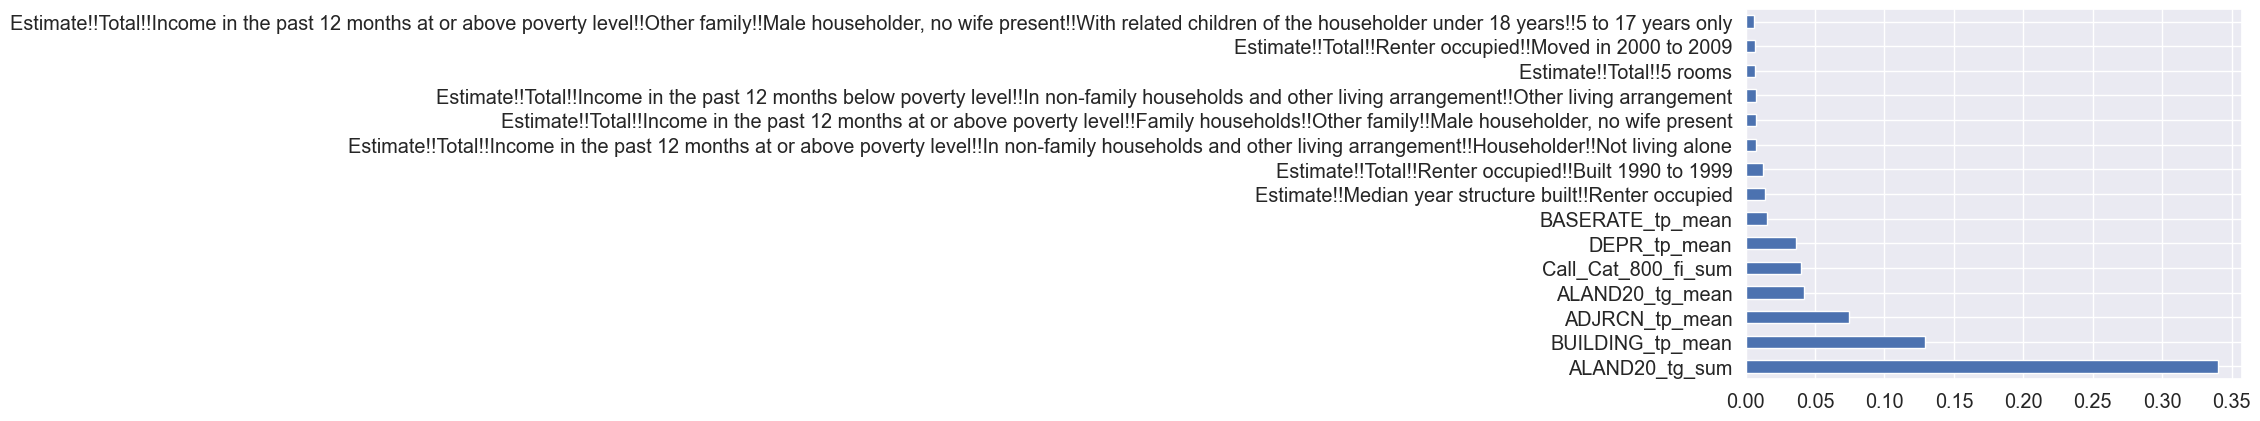

In [141]:
### Select top 10 predictors:
random.seed(1299)
feature_imp = pd.Series(rfcmf.feature_importances_, index = feature_list).sort_values(ascending = False)
feature_imp_sel = feature_imp.iloc[0:15] #33
feature_imp_sel_s = feature_imp_sel.sort_values(ascending = False)
feature_plot_1 = feature_imp_sel_s.plot.barh()  

In [142]:
#feature_imp.head(20) 


In [143]:
#For viz in Tableau
random.seed(1299)
#feature_imp_sel_df = pd.DataFrame(feature_imp_sel)
#feature_imp_sel_df.to_csv('feature_imp_sel_sum.csv',index=True, na_rep='NA' )
confusion_matrix(y_test, y_pred)  

array([[43, 14],
       [14, 91]])

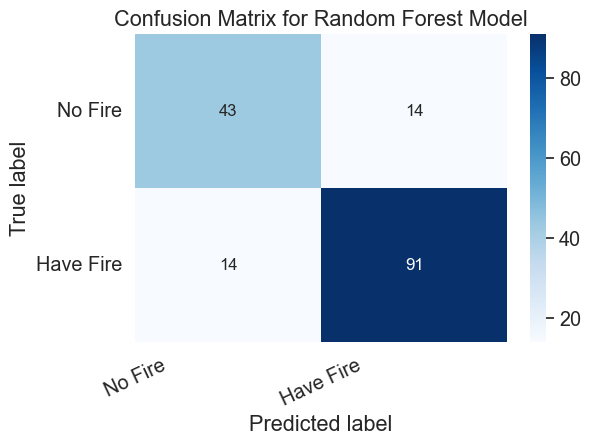

In [144]:
# Get and reshape confusion matrix data
random.seed(1299)

matrix = confusion_matrix(y_test, y_pred)
# Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1.3)
sns.heatmap(matrix, annot=True, annot_kws={'size':12},
            cmap=plt.cm.Blues)
# Add labels to the plot
class_names = ['No Fire','Have Fire']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [145]:
random.seed(1299)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
#.828, .84, .835, .839, .79, .95, 96, .94  .95  .76, .77
#.78, .82

ACCURACY OF THE MODEL:  0.8271604938271605


In [146]:
random.seed(1299)
#print(classification_report(y_test, y_pred)) #model 2, .96, .95, .96
crmf = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96


In [147]:
#cohen_kappa_score  .69, .73. .68, 10: .58  .62 76 VIF: .72, .74, .28 .24
random.seed(1299)  #.18  #.52, .53  #.49, 63
cohen_kappa_score(y_test, y_pred)


0.6210526315789473

In [148]:
#gnb = GaussianNB()
#rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=61,min_samples_leaf=3,min_samples_split=13,n_estimators=49)   
rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=63,min_samples_leaf=7,min_samples_split=9,n_estimators=47)   

abc = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=dtclf,learning_rate = 0.2,n_estimators=5, random_state=42)
rfcmf_isotonic = CalibratedClassifierCV(rfcmf, cv=2, method="isotonic")

rfcmf_sigmoid = CalibratedClassifierCV(rfcmf, cv=2, method="sigmoid")
gbc = GradientBoostingClassifier()
#lr = LogisticRegression(C=1.0)

clf_list = [#(gbc, "Gradient Boosting"),
            #(lr, "Logistic Regression"), 
            (abc,'AdaBoostClassifier'),
            (rfcmf, "Random Forest"),
            (rfcmf_sigmoid, "Random Fores + Sigmoid"),
            (rfcmf_isotonic, "Random Fores + Isotonic")
]

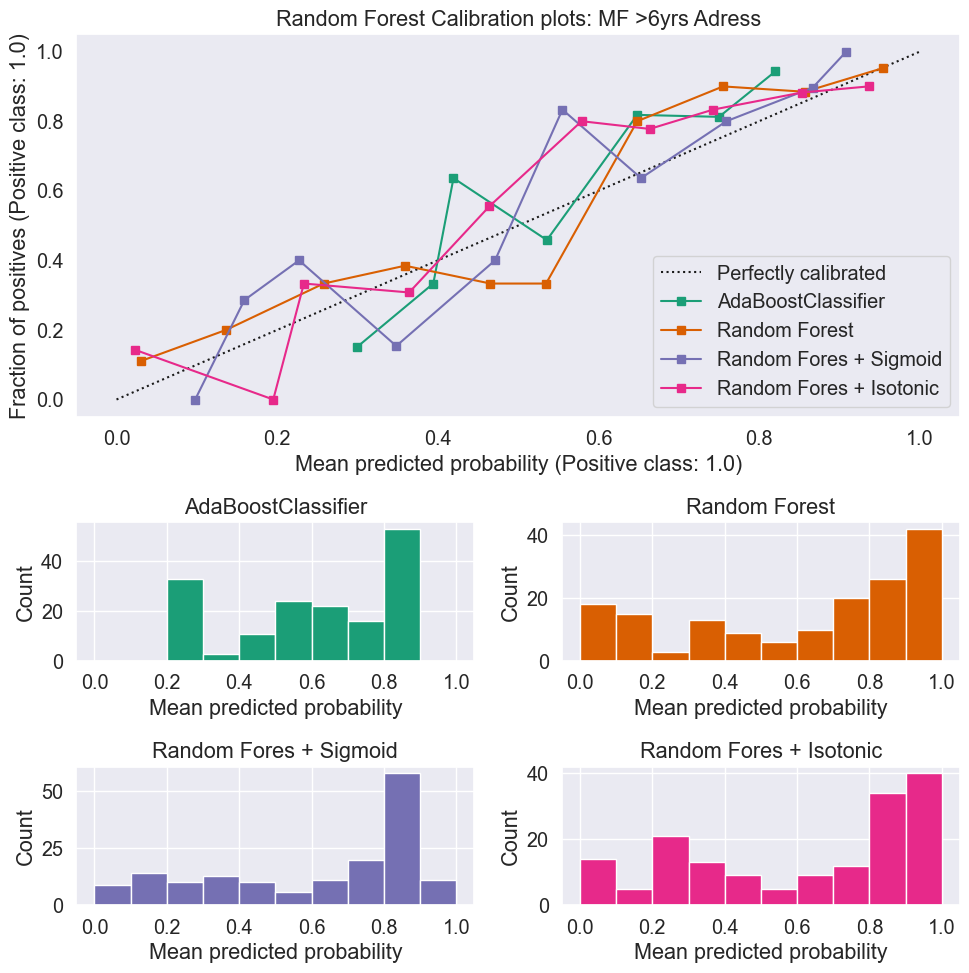

Elapsed 3741664.0 µs


In [149]:
start = datetime.now()
calibration_plots_mf = calibration_plots_processor (clf_list,"Random Forest Calibration plots: MF >6yrs Adress")
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")
calibration_plots_mf

In [150]:
start = datetime.now()
score_df_mf = calibration_report (clf_list,"Classifier MF >6yrs Adr")
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")
score_df_mf
#Random Fores + Sigmoid ** 
#* or Random Forest	
#SF: Gradient Boosting	0.17	0.52	0.80	0.69	0.65	0.67	0.75	0.47
#crsf_rfcmf_isotonic ***
#rfcmf_Sigmoid ***
#Random Forest

Elapsed 1904431.0 µs


,Brier loss,Log loss,Roc auc,Precision,Recall,F1,Accuracy,Cohen kappa
Classifier MF >6yrs Adr,,,,,,,,
AdaBoostClassifier,0.15,0.48,0.85,0.80,0.88,0.84,0.78,0.49
Random Forest,0.13,0.41,0.87,0.86,0.88,0.87,0.83,0.62
Random Fores + Sigmoid,0.14,0.44,0.86,0.87,0.87,0.87,0.83,0.62
Random Fores + Isotonic,0.14,0.42,0.87,0.87,0.86,0.86,0.82,0.61


                        Brier loss	Log loss	Roc auc	Precision	Recall	F1	Accuracy	Cohen kappa
Classifier MF >6yrs Adr								
    AdaBoostClassifier	0.16	0.50	0.88	0.90	0.78	0.84	0.80	0.59
        Random Forest	0.12	0.39	0.89	0.89	0.87	0.88	0.85	0.67
Random Fores + Sigmoid	0.12	0.40	0.90	0.89	0.85	0.87	0.83	0.64
Random Fores + Isotonic	0.13	0.40	0.89	0.93	0.84	0.88	0.85	0.69 
 
 Brier	Log   Roc/auc Precision	Recall	F1	  Accuracy	Cohen 
Classifier MF >6yrs								
    Gradient Boosting	0.13	0.43	0.90	0.89	0.80	0.84	0.81	0.60
    AdaBoostClassifier	0.14	0.44	0.92	0.90	0.78	0.84	0.80	0.59
        Random Forest	0.13	0.40	0.91	0.90	0.82	0.86	0.82	0.62
Random Fores + Sigmoid	0.13	0.40	0.91	0.91	0.83	0.87	0.83	0.65

abc = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=dtclf, learning_rate = 0.1, n_estimators=27, random_state=42)

rfcmf = RandomForestClassifier(bootstrap=False,max_depth=18,max_features=13,min_samples_leaf=3,min_samples_split=10,n_estimators=44)   





## MF Summary Analysis, >6 yr (1/1/2016-6/30/2022)

    Probability scores:  brier loss, log loss, & ROC AUC.  
    Prediction scores:   
            For "Fire"(1) only: precision, recall, f1 
            For the model:      accuracy, cohen_kappa 
    
    A lower score is better for both Brier loss and log loss: a perfect score would be "0".
    A random model's score for: Brier loss: ~ 0.25; log loss: ~ 0.693.
    Higher results are better for all other scores.

    Scores for both "Fire" (0,1) are below.


In [151]:
random.seed(1299)
rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=63,min_samples_leaf=7,min_samples_split=9,n_estimators=47)   

#rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=61,min_samples_leaf=3,min_samples_split=13,n_estimators=49)   
#abc = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=dtclf,learning_rate = 0.2,n_estimators=5, random_state=42)
rfcmf_isotonic = CalibratedClassifierCV(rfcmf, cv=2, method="isotonic")

#rfcmf_sigmoid = CalibratedClassifierCV(rfcmf, cv=2, method="sigmoid")
#gbc = GradientBoostingClassifier()  #BG_9
#gbc.fit(X_train, y_train)  
#y_pred = gbcsf.predict(X_test)
rfcmf_isotonic.fit(X_train, y_train)  
y_pred = rfcmf_isotonic.predict(X_test)

#print(classification_report(y_test, y_pred)) #model 2, .96, .95, .96
crsf_rfcmf_isotonic = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_rfcmf_isotonic)


              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75        57
         1.0       0.87      0.84      0.85       105

    accuracy                           0.81       162
   macro avg       0.80      0.81      0.80       162
weighted avg       0.82      0.81      0.82       162



In [152]:
random.seed(1299)
rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=63,min_samples_leaf=7,min_samples_split=9,n_estimators=47)   


#rfcmf_sigmoid = CalibratedClassifierCV(rfcmf, cv=2, method="sigmoid")
#gbc = GradientBoostingClassifier()  #BG_9
#gbc.fit(X_train, y_train)  
#y_pred = gbcsf.predict(X_test)
rfcmf.fit(X_train, y_train)  
y_pred = rfcmf.predict(X_test)

#print(classification_report(y_test, y_pred)) #model 2, .96, .95, .96
crsf_rfcmf = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_rfcmf)

              precision    recall  f1-score   support

         0.0       0.75      0.74      0.74        57
         1.0       0.86      0.87      0.86       105

    accuracy                           0.82       162
   macro avg       0.80      0.80      0.80       162
weighted avg       0.82      0.82      0.82       162



In [153]:
random.seed(1299)
rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=63,min_samples_leaf=7,min_samples_split=9,n_estimators=47)   

#abc = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=dtclf,learning_rate = 0.1,n_estimators=7, random_state=42)
rfcmf_sigmoid = CalibratedClassifierCV(rfcmf, cv=2, method="sigmoid")
#gbc = GradientBoostingClassifier()  #BG_9
#gbc.fit(X_train, y_train)  
#y_pred = gbcsf.predict(X_test)
rfcmf_sigmoid.fit(X_train, y_train)  
y_pred = rfcmf_sigmoid.predict(X_test)

#print(classification_report(y_test, y_pred)) #model 2, .96, .95, .96
crsf_rfcmf_sigmoid = classification_report(y_test, y_pred) #) #model 2, .96, .95, .96
print(crsf_rfcmf_sigmoid)


              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        57
         1.0       0.87      0.87      0.87       105

    accuracy                           0.83       162
   macro avg       0.81      0.81      0.81       162
weighted avg       0.83      0.83      0.83       162



# Fire Risk Prediction Tables:  MF

 

In [154]:
joined_df = joined_df_mf.copy()
#joined_df_raw_mf.shape
#joined_df.reset_index(inplace=True)
#joined_df.head(2)

In [155]:
#result_data_2 = pd.merge(result_data, tiger_2,left_on = ['BG_ID_9_tg'],right_on = ['BG_ID_9_tg'],how= 'left') 
#joined_df_raw_mf_2 = pd.merge(joined_df_raw_mf, tiger_2,left_on = ['BG_ID_6_tg'],right_on = ['BG_ID_6_tg'],how= 'left') 


In [156]:
#result_data.shape, joined_df_raw_mf.shape, joined_df_raw_mf_2.shape

In [157]:
#B w/ rfcmf_isotonic, now rfcmf
rfcmf = RandomForestClassifier(bootstrap=False,max_depth=80,max_features=63,min_samples_leaf=7,min_samples_split=9,n_estimators=47)   
rfcmf.fit(X_train, y_train)  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)
#y_pred = rfcmf.predict(X_test)

def fire_risk_tables_processor_mf (joined_df, tiger_2):
    joined_df.reset_index(inplace=True)
    predprob =rfcmf.predict_proba(joined_df.drop(['Address_tp','FireIndicator'], axis = 1))
    pd.DataFrame(predprob).shape
    result_data = pd.concat([joined_df[['Address_tp']].reset_index(drop=True),
                             pd.DataFrame(predprob[:,1],columns=['Predicted_Fire_Probability']).reset_index(drop=True)],
                             axis=1)
    joined_df_raw_mf.reset_index(inplace = True)
    data = {'Address_mf':result_data.Address_tp, 
        'Predicted_Fire_Risk_adr_mf': fire_risk(predprob[:,1]),
        'Predicted_Fire_Probability_adr_mf':predprob[:,1], 
        'geometry_adr_mf':joined_df_raw_mf.geometry,
        'Latitude_adr_mf':joined_df_raw_mf.latitude_ad, #result_r2
        'Longitude_adr_mf':joined_df_raw_mf.longitude_ad,
        'BG_ID_6':joined_df_raw_mf.BG_ID_6_tg, 
        'geometry_6':joined_df_raw_mf.geometry_6_tg,
        'HOUSING20_adr_mf':joined_df_raw_mf.HOUSING20_tg_sum, 
        'ALAND20_adr_mf':joined_df_raw_mf.ALAND20_tg_sum,
        'POP20_adr_mf':joined_df_raw_mf.POP20_tg_sum
        } 
    pred_mf_adr=pd.DataFrame(data=data)
    pred_mf_adr.sort_values(by='Predicted_Fire_Probability_adr_mf',ascending=False,inplace=True)
    pred_mf_adr.reset_index(drop=True, inplace = True)
    # groupby BG_ID_6 -> mean
    df2 = pred_mf_adr.loc[:, ('BG_ID_6','Predicted_Fire_Probability_adr_mf')]  #,'HOUSING20_9', 'POP20_9', 'ALAND20_9')]
    df2_mean = df2.groupby("BG_ID_6").mean()
    df2_mean.columns = df2_mean.columns.str.replace(r"adr_mf", "6_mf")
    # groupby BG_ID_6 -> sum
    df3 = pred_mf_adr.loc[:, ('BG_ID_6','HOUSING20_adr_mf', 'ALAND20_adr_mf', 'POP20_adr_mf')]
    df3_sum = df3.groupby("BG_ID_6").sum()
    df3_sum.columns = df3_sum.columns.str.replace(r"adr_mf", "6_mf")
    df_mean_sum =pd.concat([df2_mean, df3_sum], axis=1)
    #df_mean_sum_c = df_mean_sum.copy()
    df_mean_sum.reset_index(inplace=True)
    pred_mf_all_raw = pd.merge(df_mean_sum,pred_mf_adr,left_on = ['BG_ID_6'],right_on = ['BG_ID_6'],how= 'right') 
    
    predprob_2 = pred_mf_all_raw['Predicted_Fire_Probability_6_mf'].to_numpy()
    data_mf6 = {'BG_ID_6':pred_mf_all_raw.BG_ID_6,
            'Predicted_Fire_Probability_6_mf':predprob_2,
            'Predicted_Fire_Risk_6_mf': fire_risk(predprob_2),
            'Address_mf':pred_mf_all_raw.Address_mf,
            'Predicted_Fire_Probability_adr_mf':pred_mf_all_raw.Predicted_Fire_Probability_adr_mf, 
            'Predicted_Fire_Risk_adr_mf': pred_mf_all_raw.Predicted_Fire_Risk_adr_mf,       #fire_risk(predprob[:,1]),
            'geometry_adr_mf':pred_mf_all_raw.geometry_adr_mf,
            'Latitude_adr_mf':pred_mf_all_raw.Latitude_adr_mf, 
            'Longitude_adr_mf':pred_mf_all_raw.Longitude_adr_mf,
            'geometry_6':pred_mf_all_raw.geometry_6,
            'HOUSING20_adr_mf':pred_mf_all_raw.HOUSING20_adr_mf, 
            'ALAND20_adr_mf':pred_mf_all_raw.ALAND20_adr_mf,
            'POP20_adr_mf':pred_mf_all_raw.POP20_adr_mf,
            'HOUSING20_6_mf':pred_mf_all_raw.HOUSING20_6_mf,  #_6_mf',
            'POP20_6_mf':pred_mf_all_raw.POP20_6_mf, 
            'ALAND20_6_mf':pred_mf_all_raw.ALAND20_6_mf 
            } 
    pred_mf_all=pd.DataFrame(data=data_mf6)
    pred_mf_all.sort_values(['Predicted_Fire_Probability_6_mf','BG_ID_6','Predicted_Fire_Probability_adr_mf'],ascending=[False, True, False], inplace = True)
    pred_mf_all.reset_index(drop=True, inplace=True)
    pred_mf_all['BG_ID_6'] = pred_mf_all['BG_ID_6'].astype(str)  #.str.replace(r'\D', '', regex=True)

    tiger_2_sel = tiger_2.loc[:, ('BG_ID_6_tg', 'Station_tg', 'Battalion_tg')]  #geometry_stion_tg
    pred_mf_stion = pd.merge(tiger_2_sel,pred_mf_all,left_on = ['BG_ID_6_tg'],right_on = ['BG_ID_6'],how= 'right') 
    pred_mf_stion.drop_duplicates(['Address_mf'], inplace = True)  #drop_duplicates('Address_tp') # dropping dupl
    return pred_mf_stion

##pred_mf_stion.to_csv('pred_mf_stion.csv',index=True, na_rep='NA' )


In [158]:
start = datetime.now()
pred_mf_stion = fire_risk_tables_processor_mf (joined_df, tiger_2)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")


#pred_mf_stion.info()
#pred_mf_stion.head(2)

Elapsed 57436.0 µs


In [159]:
unique(pred_mf_stion)

,Distinct
geometry_adr_mf,647
Latitude_adr_mf,647
Address_mf,647
Longitude_adr_mf,647
ALAND20_adr_mf,592
POP20_adr_mf,577
HOUSING20_adr_mf,571
Predicted_Fire_Probability_adr_mf,540
geometry_6,225
BG_ID_6_tg,225


In [160]:
#pred_mf_stion.info()
#pred_mf_stion.head(2)

In [161]:
pred_mf_stion.shape  #BG_ID_6

(647, 19)

In [162]:
pred_mf_stion.BG_ID_6.nunique()

225

In [163]:
pred_mf_stion.to_csv('pred_mf_stion.csv',index=True, na_rep='NA' )
#pred_sf_stion.to_csv('pred_sf_stion.csv',index=True, na_rep='NA' )


In [164]:
#unique(pred_mf_stion)

In [165]:
pred_mf_stion.shape

(647, 19)

In [166]:
check_missing_values(pred_mf_stion)

'No missing values'

In [167]:

pred_mf_stion.Predicted_Fire_Risk_6_mf.value_counts()
#High Risk        182
#Low Risk          63
#Moderate Risk     61
#Low Risk         437
#High Risk        382
#Moderate Risk    221

#High Risk        330
#Low Risk         166
#Moderate Risk    151

High Risk        338
Moderate Risk    156
Low Risk         153
Name: Predicted_Fire_Risk_6_mf, dtype: int64

In [168]:
pred_mf_6 = pred_mf_stion.drop_duplicates(subset='BG_ID_6')
pred_mf_6.Predicted_Fire_Risk_6_mf.value_counts()
#High Risk        183
#Low Risk          66
#Moderate Risk     57

#High Risk: 168 Moderate Risk: 31 Low Risk: 25  BG_ID_6

High Risk        172
Moderate Risk     35
Low Risk          18
Name: Predicted_Fire_Risk_6_mf, dtype: int64

In [169]:
pred_mf_stion.Predicted_Fire_Risk_adr_mf.value_counts()
#adr_mf: High Risk:  377, Moderate Risk: 64, Low Risk: 206 
#BG_ID_6: High Risk: 168 Moderate Risk: 31 Low Risk: 25  BG_ID_6

High Risk        385
Low Risk         165
Moderate Risk     97
Name: Predicted_Fire_Risk_adr_mf, dtype: int64